# Artist classifier
This model uses feature extraction from VGG16, then feeds them into an SVM classifier to determine the artist behind a painting, from a group of a few dozen well-known artists.

## Prepare the data
+ Load the dataset from kaggle (alternatively, can do manually or from the terminal)
+ Unzip the data into the current folder
+ Import libraries and convolutional base

In [1]:
!mkdir /root/.kaggle
!echo '{"username":"yuliyashpunarska","key":"9817fefb49b3ac5fa6fbfe363a1c2485"}' > /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
# OR simply put your kaggle.json in the correct folder

In [2]:
!kaggle datasets download -d ikarus777/best-artworks-of-all-time

 99% 2.28G/2.29G [00:32<00:01, 13.7MB/s]
100% 2.29G/2.29G [00:32<00:00, 75.3MB/s]


In [3]:
# Load the dataset
import zipfile
with zipfile.ZipFile("best-artworks-of-all-time.zip","r") as zip_ref:
    zip_ref.extractall()

In [4]:
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.utils.vis_utils import plot_model
from keras.applications.imagenet_utils import decode_predictions
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras import models

from keras.utils import normalize

import tensorflow_datasets as tfds

import pandas as pd
from sklearn import preprocessing

import os
import numpy as np

%matplotlib inline 
import matplotlib.pyplot as plt

In [6]:
# Hyperparameters
MEAN_RGB = [0.485, 0.456, 0.406] # From vgg16
STDEV_RGB = [0.229, 0.224, 0.225] # From vgg16
learning_rate = 1 # Figure this out
train_input_shape = (224, 224, 3)
batch_size = 48
img_width, img_height = 224, 224
train_valid_split = 0.2

In [7]:
base_model = VGG16(include_top=False, input_shape=train_input_shape) # Import pretrained vgg16 without classifier
base_model.trainable = False

58892288/58889256 [==============================] - 1s 0us/step


## Preprocessing
+ Make a dataframe, picking which artists to keep
+ Define class weights
+ Augment data
+ Extract features

In [8]:
# Sort artists by number of paintings
artists = pd.read_csv('./artists.csv')
artists = artists.sort_values(by=['paintings'], ascending=False)

# Create a dataframe with artists having more than 100 paintings
artists_top = artists[artists['paintings'] >= 100].reset_index()
artists_top = artists_top[['name', 'paintings']].drop(index=4)
artists_top = artists_top.reset_index().drop(columns="index")
print(artists_top)
# Note: I dropped Albrecht Durer because the name of the folder is weird

# Calculate class weights (we want the smallest classes to have the highest weights to be balanced out)
# https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/
artists_top['class_weight'] = artists_top.paintings.sum()/(artists_top.shape[0]*artists_top.paintings) 
#artists_top['class_weight'] = max(artists_top.paintings)/artists_top.paintings

# Class weight dictionnary
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#calculate_class_weights 
class_weights = artists_top['class_weight'].to_dict()

                     name  paintings
0        Vincent van Gogh        877
1             Edgar Degas        702
2           Pablo Picasso        439
3   Pierre-Auguste Renoir        336
4            Paul Gauguin        311
5          Francisco Goya        291
6               Rembrandt        262
7           Alfred Sisley        259
8                  Titian        255
9            Marc Chagall        239
10          Rene Magritte        194
11      Amedeo Modigliani        193
12              Paul Klee        188
13          Henri Matisse        186
14            Andy Warhol        181
15         Mikhail Vrubel        171
16      Sandro Botticelli        164
17      Leonardo da Vinci        143
18      Peter Paul Rubens        141
19          Salvador Dali        139
20       Hieronymus Bosch        137
21         Pieter Bruegel        134
22        Diego Velazquez        128
23       Kazimir Malevich        126
24            Frida Kahlo        120
25      Giotto di Bondone        119
2

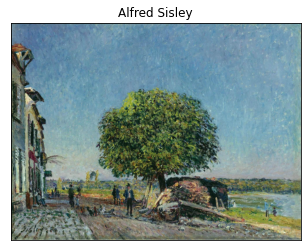

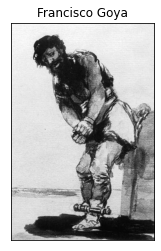

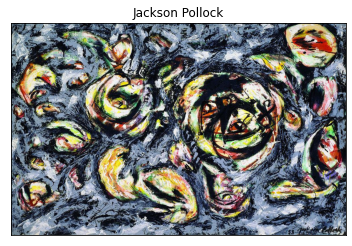

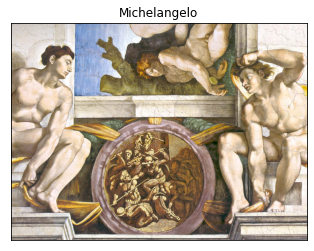

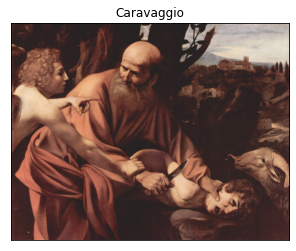

In [9]:
images_dir = './images/images/'
artists_dirs = os.listdir(images_dir)

# Preview a few images
for i in range(5):
  path = images_dir + artists_dirs[i] + "/" + os.listdir(images_dir + artists_dirs[i])[0]
  image = load_img(path) # returns a PIL image
  fig, ax = plt.subplots()
  im = ax.imshow(image)
  ax.set_title(artists_dirs[i].replace("_", " "))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.show()

In [23]:
# Make a list of classes for data augmentation
names_top_artists = artists_top["name"].tolist()
for i, artist in enumerate(names_top_artists):
  names_top_artists[i] = artist.replace(" ", "_")

In [26]:
# Augment data
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255,
                             zoom_range=0.3,
                             horizontal_flip=True,
                             vertical_flip=True,
                             validation_split = train_valid_split)

n_classes = artists_top.shape[0]-1

# Extract features
def extract_features(directory, subset:str):

    """ Returns an array of features for the entire dataset, and each image's 
    corresponding labels """

    # Prepare dataset used for this pass (e.g. training, validation, or testing)
    generator = datagen.flow_from_directory(directory,
                                            classes = names_top_artists,
                                            target_size = (img_width,img_height),
                                            batch_size = batch_size,
                                            class_mode = 'sparse',
                                            subset = subset)
    
    sample_count = generator.samples

    features = np.zeros(shape=(sample_count, 7, 7, 512))
    labels = np.zeros(shape=(sample_count)) # Expect one label (as an int) per sample image
    
    # Store the number of batches
    n_batches = sample_count//batch_size

    # Generator returns a batch of images in numpy array of shape (batch_size, 224, 224, 3)
    # and a numpy array of labels (one for each image) of size (batch_size,)

    # Pass each batch through the base model
    print("Found {} batches to process.".format(n_batches))
    print()

    for i, (batch, labels_batch) in enumerate(generator):
      print("Processing batch", i, "out of", n_batches)
      print("At index:", i*batch_size)
      
      features_batch = base_model.predict(batch) # Predict features for this batch

      if n_batches != len(generator): # If there is an incomplete batch at the end
        if i == len(generator)-1:
          print("Processing incomplete batch ({} elements)".format(sample_count - i*batch_size))
          end_slice = i*batch_size + (sample_count - i*batch_size)
          features[i*batch_size:end_slice] = features_batch # select a slice corresponding to this batch
          labels[i*batch_size:end_slice] = labels_batch
          break
        else:
          features[i*batch_size:(i+1)*batch_size] = features_batch # select a slice corresponding to this batch
          labels[i*batch_size:(i+1)*batch_size] = labels_batch
      
      else: # if everything is normal (exact number of batches)
        if i == len(generator): break
        else:
          features[i*batch_size:(i+1)*batch_size] = features_batch # select a slice corresponding to this batch
          labels[i*batch_size:(i+1)*batch_size] = labels_batch
      print()

    print("Done.")
    return features, labels 

In [27]:
train_features, train_labels = extract_features(images_dir, "training")

Found 5424 images belonging to 29 classes.
Found 113 batches to process.

Processing batch 0 out of 113
At index: 0

Processing batch 1 out of 113
At index: 48

Processing batch 2 out of 113
At index: 96

Processing batch 3 out of 113
At index: 144

Processing batch 4 out of 113
At index: 192

Processing batch 5 out of 113
At index: 240

Processing batch 6 out of 113
At index: 288

Processing batch 7 out of 113
At index: 336

Processing batch 8 out of 113
At index: 384

Processing batch 9 out of 113
At index: 432

Processing batch 10 out of 113
At index: 480

Processing batch 11 out of 113
At index: 528

Processing batch 12 out of 113
At index: 576

Processing batch 13 out of 113
At index: 624

Processing batch 14 out of 113
At index: 672

Processing batch 15 out of 113
At index: 720

Processing batch 16 out of 113
At index: 768

Processing batch 17 out of 113
At index: 816

Processing batch 18 out of 113
At index: 864

Processing batch 19 out of 113
At index: 912

Processing batch 20 

In [28]:
valid_features, valid_labels = extract_features(images_dir, "validation")

Found 1339 images belonging to 29 classes.
Found 27 batches to process.

Processing batch 0 out of 27
At index: 0

Processing batch 1 out of 27
At index: 48

Processing batch 2 out of 27
At index: 96

Processing batch 3 out of 27
At index: 144

Processing batch 4 out of 27
At index: 192

Processing batch 5 out of 27
At index: 240

Processing batch 6 out of 27
At index: 288

Processing batch 7 out of 27
At index: 336

Processing batch 8 out of 27
At index: 384

Processing batch 9 out of 27
At index: 432

Processing batch 10 out of 27
At index: 480

Processing batch 11 out of 27
At index: 528

Processing batch 12 out of 27
At index: 576

Processing batch 13 out of 27
At index: 624

Processing batch 14 out of 27
At index: 672

Processing batch 15 out of 27
At index: 720

Processing batch 16 out of 27
At index: 768

Processing batch 17 out of 27
At index: 816

Processing batch 18 out of 27
At index: 864

Processing batch 19 out of 27
At index: 912

Processing batch 20 out of 27
At index: 9

In [29]:
# Sanity check
print(valid_features.shape, valid_labels.shape)
print(train_features.shape, train_labels.shape)

(1339, 7, 7, 512) (1339,)
(5424, 7, 7, 512) (5424,)


## Train the classifier

In [30]:
from keras import models
from keras import layers
from keras import optimizers

# Build model
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC

X_train, y_train = train_features.reshape((len(train_features), 7*7*512)), train_labels

#param_grid = [{"C": [1, 10, 100, 1000]}]

svm = LinearSVC(penalty='l2', loss='squared_hinge', max_iter=100000, class_weight=class_weights)
#clf = GridSearchCV(svm, param_grid, cv=5)
model = svm.fit(X_train, y_train)

## Evaluate performance and test a custom image

In [57]:
# Check the model accuracy on the validation set
# Not very good... for now
accuracy = model.score(valid_features.reshape((len(valid_features), 7*7*512)), valid_labels)
print("Accuracy: {}%".format(round(accuracy*100, 1)))

Accuracy: 46.2%


In [52]:
def normalize(link):
  image = load_img(link, target_size=(224, 224)) # returns a PIL image
  image = img_to_array(image) # turn into array
  # reshape into correct format for the model (samples x H x W x channels)
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2])) 
  return image

def predict_result(path):
  image = normalize(path)
  features = base_model.predict(image)
  yhat = model.predict(features.reshape((1, 7*7*512)))

  return names_top_artists[int(yhat)].replace("_", " ")

def preview_image(path):
  image = load_img(path) # returns a PIL image
  fig, ax = plt.subplots()
  im = ax.imshow(image)
  ax.set_title('Input image')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.show()

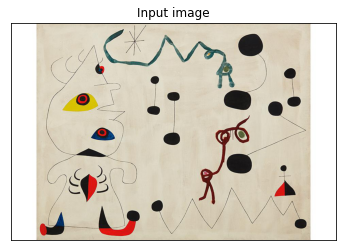

The artist is Joan Miro


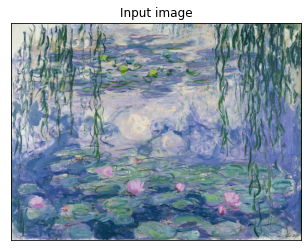

The artist is Hieronymus Bosch


In [54]:
# Upload your own images to test!
image_path = "/content/miro-2.jpg"
preview_image(image_path)
print("The artist is", predict_result(image_path))


image_path = "/content/monet.jpg"
preview_image(image_path)
print("The artist is", predict_result(image_path))